# Импорт библиотек и чтение датасетов

In [662]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Загрузка данных
train_data = pd.read_excel("data/train.xlsx")
test_data = pd.read_excel("data/test.xlsx")

Преодобратока данных для обучения модели

In [663]:
# Объединение данных (если test не является независимой выборкой)
combined_df = pd.concat([train_data, test_data], ignore_index=True)
combined_df['dt'] = pd.to_datetime(combined_df['dt'])
combined_df = combined_df.sort_values(by='dt').drop_duplicates()

# Генерация временных признаков
combined_df['day_of_week'] = combined_df['dt'].dt.dayofweek
combined_df['is_month_start'] = combined_df['dt'].dt.is_month_start.astype(int)
combined_df['quarter'] = combined_df['dt'].dt.quarter
combined_df['year'] = combined_df['dt'].dt.year
combined_df['month'] = combined_df['dt'].dt.month
combined_df['week'] = combined_df['dt'].dt.isocalendar().week

# Добавление лагов и скользящих средних
lags = [1, 2, 3, 4, 5, 6]
for lag in lags:
    combined_df[f'lag_{lag}'] = combined_df['Price'].shift(lag)

combined_df['rolling_mean_8'] = combined_df['Price'].rolling(8).mean()
combined_df['rolling_mean_16'] = combined_df['Price'].rolling(16).mean()
combined_df = combined_df.dropna()

combined_df.to_excel("combined_data.xlsx", index=False)
print("Объединенные данные сохранены в файл 'combined_data.xlsx'.")

Объединенные данные сохранены в файл 'combined_data.xlsx'.


Разделение данных на обучающие и тестовые. Обучение модели. Метрики

In [664]:
combined_df = pd.read_excel("combined_data.xlsx")

# Разделение данных
combined_df = combined_df.set_index('dt')
split_idx = int(len(combined_df) * 0.8)
train = combined_df.iloc[:split_idx]
test = combined_df.iloc[split_idx:]

X_train = train.drop('Price', axis=1)
y_train = train['Price']
X_test = test.drop('Price', axis=1)
y_test = test['Price']

# Логарифмирование целевой переменной
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Обучение модели CatBoost с оптимизированными параметрами
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.04,
    depth=1,
    loss_function='MAE',
    early_stopping_rounds=100,
    verbose=1
)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

# Предсказание и обратное преобразование
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)

# Метрики
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

0:	learn: 0.1859802	test: 0.4396873	best: 0.4396873 (0)	total: 382us	remaining: 191ms
1:	learn: 0.1818773	test: 0.4341510	best: 0.4341510 (1)	total: 556us	remaining: 139ms
2:	learn: 0.1790631	test: 0.4288360	best: 0.4288360 (2)	total: 669us	remaining: 111ms
3:	learn: 0.1752922	test: 0.4237337	best: 0.4237337 (3)	total: 771us	remaining: 95.7ms
4:	learn: 0.1716836	test: 0.4188356	best: 0.4188356 (4)	total: 872us	remaining: 86.4ms
5:	learn: 0.1684604	test: 0.4141333	best: 0.4141333 (5)	total: 1.13ms	remaining: 93ms
6:	learn: 0.1651412	test: 0.4112731	best: 0.4112731 (6)	total: 1.29ms	remaining: 91.1ms
7:	learn: 0.1627806	test: 0.4064702	best: 0.4064702 (7)	total: 1.52ms	remaining: 93.8ms
8:	learn: 0.1591735	test: 0.4043409	best: 0.4043409 (8)	total: 1.67ms	remaining: 91.1ms
9:	learn: 0.1572155	test: 0.4002184	best: 0.4002184 (9)	total: 1.85ms	remaining: 90.7ms
10:	learn: 0.1548012	test: 0.3963622	best: 0.3963622 (10)	total: 2.01ms	remaining: 89.4ms
11:	learn: 0.1515591	test: 0.3945234	bes

Проверка работы модели на графике

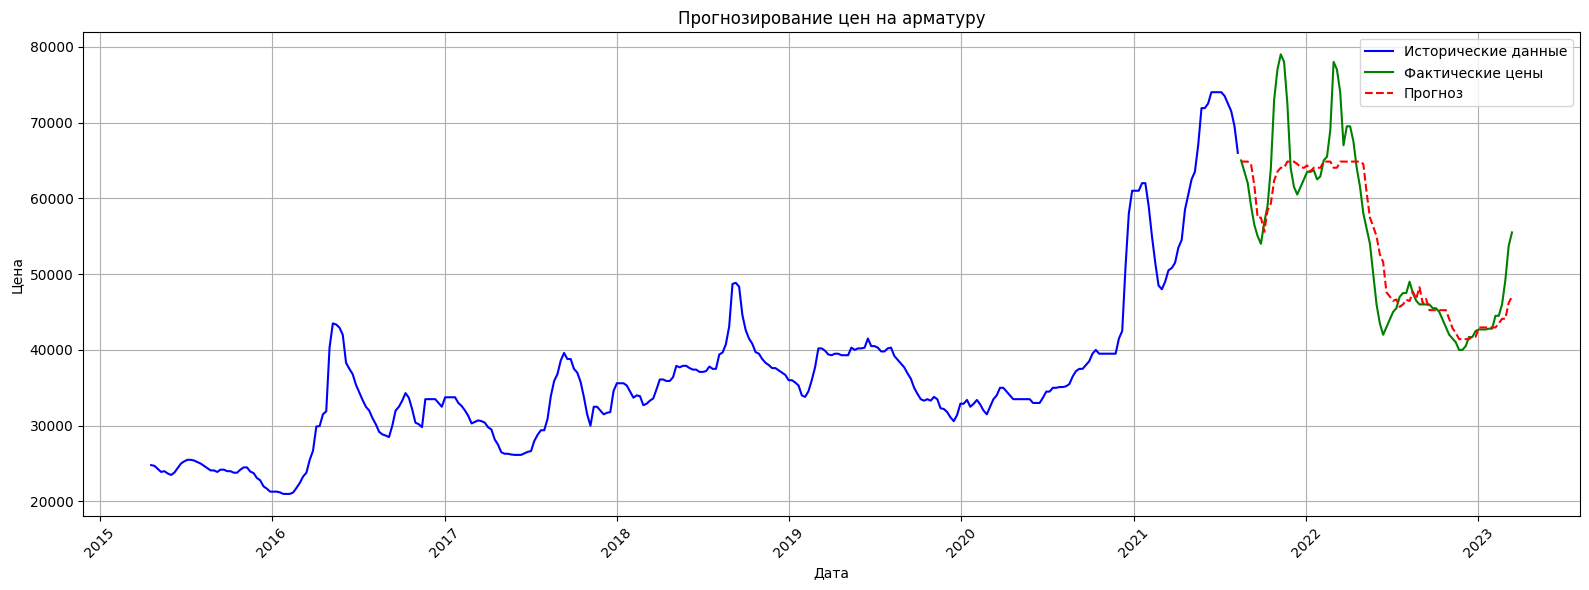

Оптимизированная модель сохранена!


In [665]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Price'], label='Исторические данные', color='blue')
plt.plot(test.index, test['Price'], label='Фактические цены', color='green')
plt.plot(test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(model, "catboost_model.pkl")
print("Оптимизированная модель сохранена!")

In [666]:
print(test_data.columns)

Index(['dt', 'Price'], dtype='object')


#### Визуализация данных для обучения

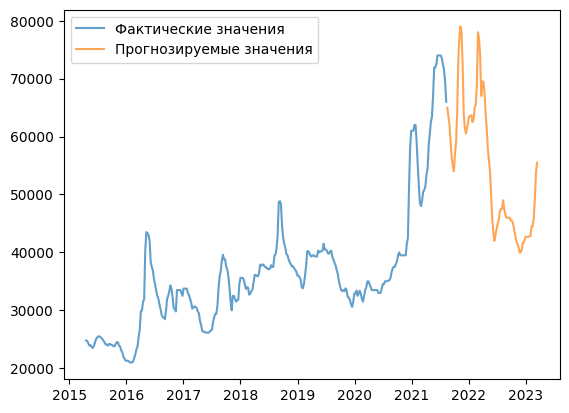

In [667]:
plt.plot(y_train, label="Фактические значения", alpha=0.7)
plt.plot(y_test, label="Прогнозируемые значения", alpha=0.7)
plt.legend()
plt.show()